In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM, GRU

(26304, 20)
       Atm Pressure   Temperature  ...    NOx_Target     CO_Traget
count  26304.000000  26304.000000  ...  26304.000000  26304.000000
mean     982.872928     25.296901  ...     92.176075   2342.513856
std        6.896038      8.298764  ...     96.524148   2065.708431
min      914.040000      4.060000  ...      2.910000     48.500000
25%      977.060000     18.867000  ...     31.675750   1250.000000
50%      982.797000     26.920000  ...     60.400000   1790.000000
75%      988.850000     31.367000  ...    115.000000   2690.000000
max      999.390000     44.400000  ...   1090.000000  38300.000000

[8 rows x 20 columns]


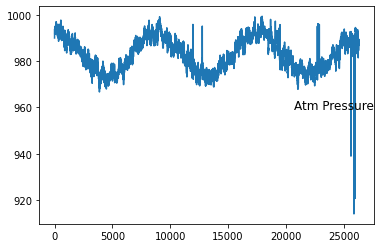

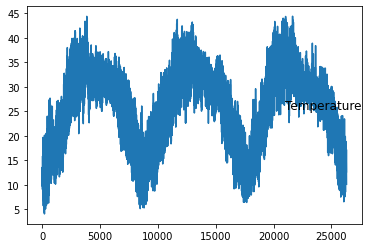

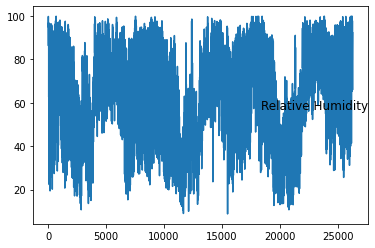

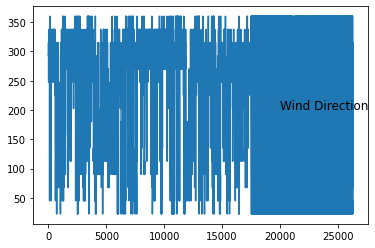

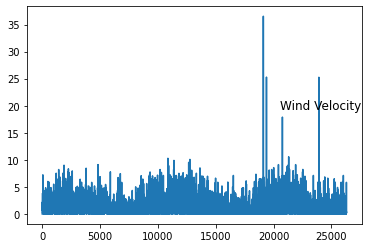

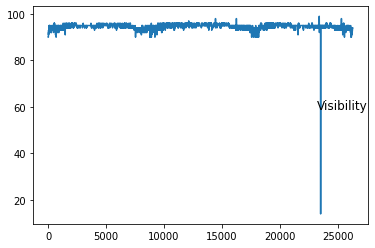

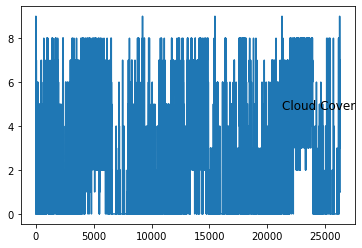

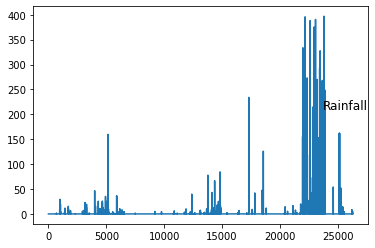

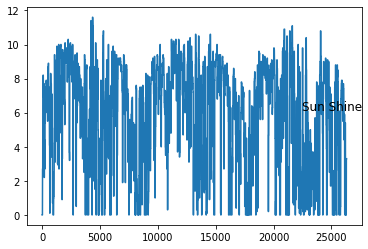

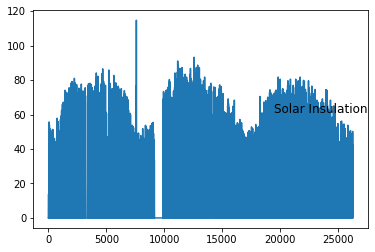

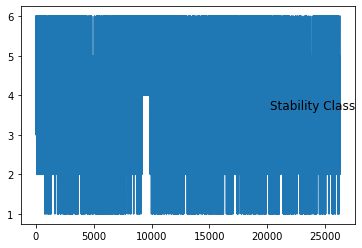

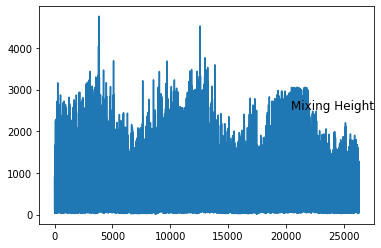

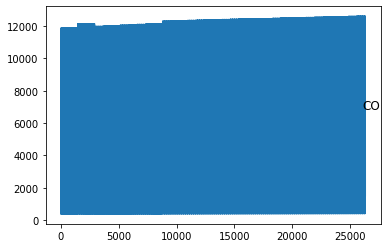

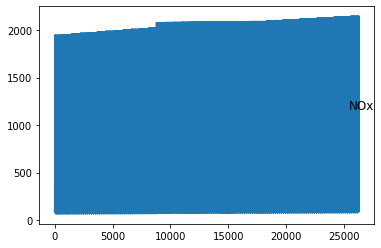

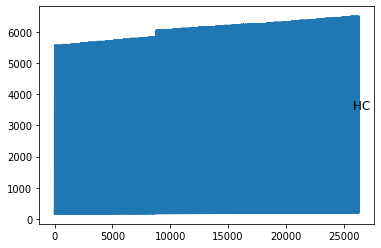

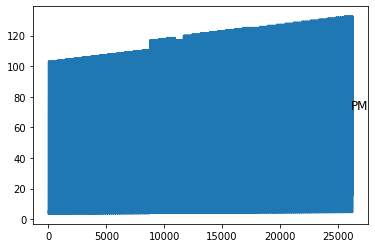

In [2]:
dataframe = read_csv('/content/drive/MyDrive/inno/data.csv', header=0, index_col=0)
dataframe.drop(['Gasoline',	'Diesel',	'CNG',	'LPG'],axis=1, inplace=True)
print(dataframe.shape)
print(dataframe.describe())
dataset = dataframe.values
def ploter(groups):
  i = 1
  for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(dataset[:, group])
    pyplot.title(dataframe.columns[group], y=0.5, loc='right')
    i += 1
  pyplot.show()
for i in range(0,16):
    group = [i]
    ploter(group)

In [3]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[ 990.     ,    9.8    ,   95.     , ...,  229.     ,  147.     ,
        3840.     ],
       [ 990.435  ,   10.148  ,   95.87   , ...,  228.23685,  149.     ,
        3490.     ],
       [ 990.87   ,   10.496  ,   96.739  , ...,  227.47368,   92.1    ,
        2970.     ],
       ...,
       [ 988.823  ,   10.607  ,   91.133  , ...,  145.     ,   38.3    ,
         991.667  ],
       [ 989.19   ,   10.14   ,   91.8    , ...,  146.     ,   37.     ,
         923.333  ],
       [ 989.319  ,   10.106  ,   92.189  , ...,  141.     ,   56.7    ,
         855.     ]], dtype=float32)

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
data = np.concatenate((dataset[:,0:16], dataset[:,16:17]), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())

(26304, 17)
(26303, 18)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var16(t-1)  var17(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.015478    0.014060  0.895079
2   0.895079   0.150917   0.956813  ...    0.000000    0.013539  0.900175
3   0.900175   0.159544   0.966363  ...    0.018289    0.013594  0.906349
4   0.906349   0.162122   0.976923  ...    0.074889    0.013539  0.912982
5   0.912982   0.162122   0.987912  ...    0.131481    0.015019  0.919625

[5 rows x 18 columns]


In [6]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 17) (21042,) (5261, 1, 17) (5261,)


Epoch 1/73
281/281 - 3s - loss: 0.0719 - val_loss: 0.0920
Epoch 2/73
281/281 - 1s - loss: 0.0416 - val_loss: 0.0802
Epoch 3/73
281/281 - 1s - loss: 0.0376 - val_loss: 0.0727
Epoch 4/73
281/281 - 1s - loss: 0.0344 - val_loss: 0.0675
Epoch 5/73
281/281 - 1s - loss: 0.0322 - val_loss: 0.0628
Epoch 6/73
281/281 - 1s - loss: 0.0295 - val_loss: 0.0592
Epoch 7/73
281/281 - 1s - loss: 0.0280 - val_loss: 0.0540
Epoch 8/73
281/281 - 1s - loss: 0.0264 - val_loss: 0.0514
Epoch 9/73
281/281 - 1s - loss: 0.0245 - val_loss: 0.0482
Epoch 10/73
281/281 - 1s - loss: 0.0230 - val_loss: 0.0429
Epoch 11/73
281/281 - 1s - loss: 0.0233 - val_loss: 0.0420
Epoch 12/73
281/281 - 1s - loss: 0.0222 - val_loss: 0.0428
Epoch 13/73
281/281 - 1s - loss: 0.0215 - val_loss: 0.0368
Epoch 14/73
281/281 - 1s - loss: 0.0206 - val_loss: 0.0359
Epoch 15/73
281/281 - 1s - loss: 0.0189 - val_loss: 0.0303
Epoch 16/73
281/281 - 1s - loss: 0.0181 - val_loss: 0.0265
Epoch 17/73
281/281 - 1s - loss: 0.0174 - val_loss: 0.0238
Epoch 

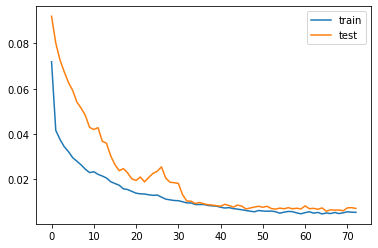

In [7]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=73, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.485
Test CC(Corelation Coefficient)     : 0.983
Test PB(Percentage Bias)            : -0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.946


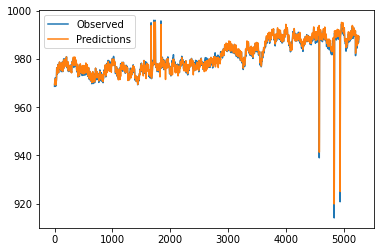

In [8]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [9]:
data = np.concatenate((dataset[:,0:16], dataset[:,17:18]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


[[ 990.         9.8       95.      ...  259.155      5.486    229.     ]
 [ 990.435     10.148     95.87    ...  158.559      3.487    228.23685]
 [ 990.87      10.496     96.739   ...  229.421      5.849    227.47368]
 ...
 [ 988.823     10.607     91.133   ... 1216.352     30.388    145.     ]
 [ 989.19      10.14      91.8     ...  961.742     22.422    146.     ]
 [ 989.319     10.106     92.189   ...  734.224     15.984    141.     ]]
(26303, 18)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var16(t-1)  var17(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.015478    0.213692  0.895079
2   0.895079   0.150917   0.956813  ...    0.000000    0.212961  0.900175
3   0.900175   0.159544   0.966363  ...    0.018289    0.212230  0.906349
4   0.906349   0.162122   0.976923  ...    0.074889    0.211499  0.912982
5   0.912982   0.162122   0.987912  ...    0.131481    0.210768  0.919625

[5 rows x 18 columns]


In [10]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 17) (21042,) (5261, 1, 17) (5261,)


Epoch 1/72
264/264 - 3s - loss: 0.0708 - val_loss: 0.0871
Epoch 2/72
264/264 - 1s - loss: 0.0362 - val_loss: 0.0796
Epoch 3/72
264/264 - 1s - loss: 0.0335 - val_loss: 0.0711
Epoch 4/72
264/264 - 1s - loss: 0.0307 - val_loss: 0.0604
Epoch 5/72
264/264 - 1s - loss: 0.0284 - val_loss: 0.0537
Epoch 6/72
264/264 - 1s - loss: 0.0248 - val_loss: 0.0436
Epoch 7/72
264/264 - 1s - loss: 0.0235 - val_loss: 0.0414
Epoch 8/72
264/264 - 1s - loss: 0.0223 - val_loss: 0.0398
Epoch 9/72
264/264 - 1s - loss: 0.0206 - val_loss: 0.0374
Epoch 10/72
264/264 - 1s - loss: 0.0195 - val_loss: 0.0320
Epoch 11/72
264/264 - 1s - loss: 0.0173 - val_loss: 0.0341
Epoch 12/72
264/264 - 1s - loss: 0.0163 - val_loss: 0.0438
Epoch 13/72
264/264 - 1s - loss: 0.0185 - val_loss: 0.0257
Epoch 14/72
264/264 - 1s - loss: 0.0151 - val_loss: 0.0360
Epoch 15/72
264/264 - 1s - loss: 0.0170 - val_loss: 0.0229
Epoch 16/72
264/264 - 1s - loss: 0.0150 - val_loss: 0.0187
Epoch 17/72
264/264 - 1s - loss: 0.0145 - val_loss: 0.0256
Epoch 

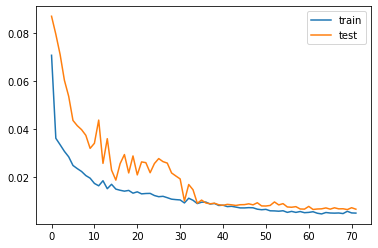

In [11]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.426
Test CC(Corelation Coefficient)     : 0.987
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.951


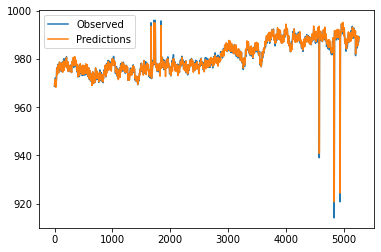

In [12]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [13]:
data = np.concatenate((dataset[:,0:16], dataset[:,18:19]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


[[ 990.       9.8     95.    ...  259.155    5.486  147.   ]
 [ 990.435   10.148   95.87  ...  158.559    3.487  149.   ]
 [ 990.87    10.496   96.739 ...  229.421    5.849   92.1  ]
 ...
 [ 988.823   10.607   91.133 ... 1216.352   30.388   38.3  ]
 [ 989.19    10.14    91.8   ...  961.742   22.422   37.   ]
 [ 989.319   10.106   92.189 ...  734.224   15.984   56.7  ]]
(26303, 18)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var16(t-1)  var17(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.015478    0.132547  0.895079
2   0.895079   0.150917   0.956813  ...    0.000000    0.134386  0.900175
3   0.900175   0.159544   0.966363  ...    0.018289    0.082045  0.906349
4   0.906349   0.162122   0.976923  ...    0.074889    0.073950  0.912982
5   0.912982   0.162122   0.987912  ...    0.131481    0.067051  0.919625

[5 rows x 18 columns]


In [14]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 17) (21042,) (5261, 1, 17) (5261,)


Epoch 1/72
121/121 - 2s - loss: 0.1537 - val_loss: 0.0793
Epoch 2/72
121/121 - 0s - loss: 0.0683 - val_loss: 0.0793
Epoch 3/72
121/121 - 0s - loss: 0.0773 - val_loss: 0.0770
Epoch 4/72
121/121 - 0s - loss: 0.0889 - val_loss: 0.0709
Epoch 5/72
121/121 - 0s - loss: 0.0851 - val_loss: 0.0643
Epoch 6/72
121/121 - 0s - loss: 0.0799 - val_loss: 0.0595
Epoch 7/72
121/121 - 0s - loss: 0.0730 - val_loss: 0.0563
Epoch 8/72
121/121 - 0s - loss: 0.0670 - val_loss: 0.0545
Epoch 9/72
121/121 - 0s - loss: 0.0620 - val_loss: 0.0530
Epoch 10/72
121/121 - 0s - loss: 0.0590 - val_loss: 0.0515
Epoch 11/72
121/121 - 0s - loss: 0.0569 - val_loss: 0.0500
Epoch 12/72
121/121 - 0s - loss: 0.0551 - val_loss: 0.0486
Epoch 13/72
121/121 - 0s - loss: 0.0531 - val_loss: 0.0472
Epoch 14/72
121/121 - 0s - loss: 0.0519 - val_loss: 0.0459
Epoch 15/72
121/121 - 0s - loss: 0.0509 - val_loss: 0.0448
Epoch 16/72
121/121 - 0s - loss: 0.0497 - val_loss: 0.0438
Epoch 17/72
121/121 - 0s - loss: 0.0487 - val_loss: 0.0428
Epoch 

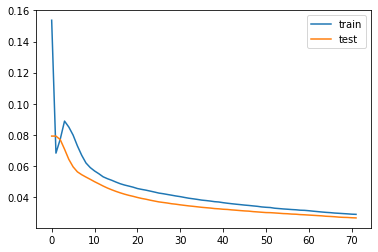

In [15]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 3.502
Test CC(Corelation Coefficient)     : 0.897
Test PB(Percentage Bias)            : -0.001
Test NSE(Nash Sutcliffe Efficiency) : 0.702


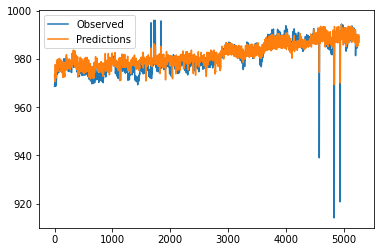

In [16]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [17]:
z =  dataset[:,19]
z = z.reshape(z.shape[0],1)
data = np.concatenate((dataset[:,0:16],z), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


(26304, 17)
(26303, 18)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var16(t-1)  var17(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.015478    0.099120  0.895079
2   0.895079   0.150917   0.956813  ...    0.000000    0.089970  0.900175
3   0.900175   0.159544   0.966363  ...    0.018289    0.076376  0.906349
4   0.906349   0.162122   0.976923  ...    0.074889    0.071932  0.912982
5   0.912982   0.162122   0.987912  ...    0.131481    0.064612  0.919625

[5 rows x 18 columns]


In [18]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 17) (21042,) (5261, 1, 17) (5261,)


Epoch 1/69
222/222 - 3s - loss: 0.0792 - val_loss: 0.0817
Epoch 2/69
222/222 - 1s - loss: 0.0411 - val_loss: 0.0613
Epoch 3/69
222/222 - 0s - loss: 0.0358 - val_loss: 0.0530
Epoch 4/69
222/222 - 0s - loss: 0.0330 - val_loss: 0.0475
Epoch 5/69
222/222 - 0s - loss: 0.0307 - val_loss: 0.0444
Epoch 6/69
222/222 - 0s - loss: 0.0283 - val_loss: 0.0429
Epoch 7/69
222/222 - 0s - loss: 0.0272 - val_loss: 0.0405
Epoch 8/69
222/222 - 0s - loss: 0.0254 - val_loss: 0.0406
Epoch 9/69
222/222 - 0s - loss: 0.0245 - val_loss: 0.0396
Epoch 10/69
222/222 - 0s - loss: 0.0236 - val_loss: 0.0381
Epoch 11/69
222/222 - 0s - loss: 0.0226 - val_loss: 0.0378
Epoch 12/69
222/222 - 0s - loss: 0.0218 - val_loss: 0.0369
Epoch 13/69
222/222 - 0s - loss: 0.0212 - val_loss: 0.0369
Epoch 14/69
222/222 - 0s - loss: 0.0205 - val_loss: 0.0337
Epoch 15/69
222/222 - 0s - loss: 0.0200 - val_loss: 0.0342
Epoch 16/69
222/222 - 0s - loss: 0.0194 - val_loss: 0.0325
Epoch 17/69
222/222 - 0s - loss: 0.0187 - val_loss: 0.0313
Epoch 

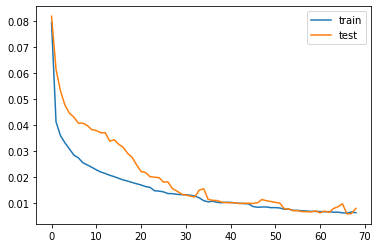

In [19]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=69, batch_size=95, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.453
Test CC(Corelation Coefficient)     : 0.990
Test PB(Percentage Bias)            : -0.001
Test NSE(Nash Sutcliffe Efficiency) : 0.949


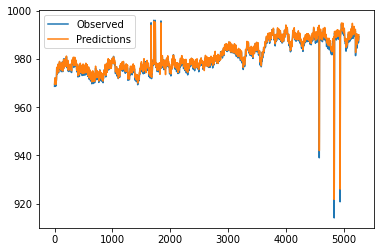

In [20]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()